In [ ]:
!pip install -q condacolab
!python -c "import condacolab; condacolab.install()"
!conda config --add channels bioconda
!conda config --add channels conda-forge
!conda config --set channel_priority strict

!conda create -y -c conda-forge -c bioconda -n amrfinder --strict-channel-priority ncbi-amrfinderplus
!conda init
!source activate amrfinder
!conda install blast ncbi-amrfinderplus blast hmmer biopython
!pip install orffinder
!amrfinder -u

In [ ]:
from orffinder import orffinder
from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm
join = os.path.join

In [ ]:
root_dir='/content/drive/MyDrive/igem-2024'

In [ ]:
json_dict = {}
with open(join(root_dir, 'finetune_2024-09-07-10-59_samples.json'), 'r') as f:
    json_dict = json.load(f)

In [ ]:
protein_dirs = 'finetune_fasta_samples'
os.makedirs(join(root_dir, protein_dirs), exist_ok=True)

In [ ]:
length_lst = []
for i in range(len(json_dict['data'])):
    length_lst.append(len(json_dict['data'][i][0]))
print(np.unique(np.array(length_lst)))

[1887 2047]


In [ ]:
for i in tqdm(range(1, 11)):
  with open(join(root_dir, protein_dirs, f'finetune_sample_part{str(i)}.fasta'), 'w') as f:
    for j, row in enumerate(json_dict['data']):
        if (i-1)*1000 < j < i*1000:
          f.write(f'>sp{j}\n{row[0]}\n')


In [ ]:
sample_seq = ">sp|"+json_dict['data'][0][0]

In [ ]:
sample_seq

In [ ]:
os.makedirs(join(root_dir, 'amrfinder_dna_samples'), exist_ok=True)

# **Blast finetuned DNA plasmid sequences against AMRFinderPlus Database for protein**
Criteria/Thresholds:
- --plus: blast against additional
protein databases: AMR, virulence, stress response (biocide, metal, heat resistance), atigens, porins
- -O Escheria: only on E Coli
- --flank_size 100: exend an additional 100 bq flanking sequence to identified sequences along the 5' direction
- --coverage_min 0.2: minimum identity coverage cutoff = 20% (current lowest maximum identity matches achieved by ProGen)


In [ ]:
def run_amrfinder(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for filename in tqdm(os.listdir(input_folder)):
        filepath = os.path.join(input_folder, filename)

        if os.path.isfile(filepath):
            output_seq_dir = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}.fasta")
            output_metadata_dir = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}.tsv")
            with open(output_metadata_dir, 'w') as f:
              !amrfinder -n $filepath \
                        --plus \
                        --threads 4 \
                        -O Escherichia \
                        --nucleotide_flank5_output $output_seq_dir \
                        --nucleotide_flank5_size 100 \
                        --coverage_min 0.2 \
                        > $output_metadata_dir

run_amrfinder(input_folder=join(root_dir, 'finetune_fasta_samples'),
              output_folder=join(root_dir, 'amrfinder_output'))

100%|██████████| 10/10 [00:00<00:00, 100.34it/s]


In [ ]:
import glob
with open(join(root_dir, "all_finetune_amrfinder_output.tsv"), "w") as outfile:
  included_header = False
  for in_path in glob.glob(join(root_dir, "amrfinder_output", "*.tsv")):
    header_line = True
    with open(in_path) as infile:
      for line in infile:
        if header_line:
          if not included_header:
            outfile.write(line)
            included_header = True
          header_line = False
        else:
          outfile.write(line)


# **Some metadata of identified protein sequences**

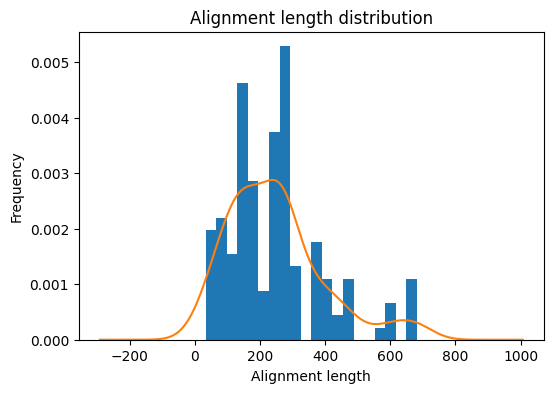

In [ ]:
aa_seq_df = pd.read_csv(join(root_dir, "all_finetune_amrfinder_output.tsv"), sep="\t")
fig, ax = plt.subplots(figsize=(6, 4))
aa_seq_df['Alignment length'].plot(kind='hist', density=True, bins=20)
aa_seq_df['Alignment length'].plot(kind='kde')
ax.set_xlabel('Alignment length')
ax.set_ylabel('Frequency')
ax.set_title('Alignment length distribution')
plt.show()
plt.save(join(root_dir, 'alignment_length_distribution.png'))


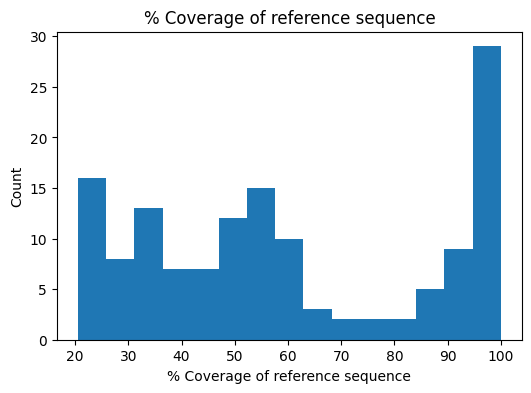

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
aa_seq_df['% Coverage of reference sequence'].plot(kind='hist', density=False, bins=15)
ax.set_xlabel('% Coverage of reference sequence')
ax.set_ylabel('Count')
ax.set_title('% Coverage of reference sequence')

plt.show()
plt.save(join(root_dir, 'coverage_distribution.png'))

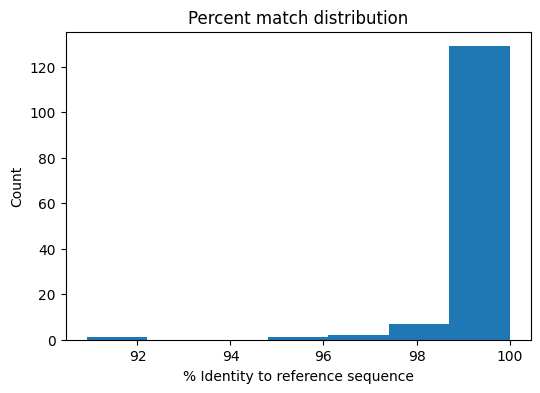

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
aa_seq_df['% Identity to reference sequence'].plot(kind='hist', density=False, bins=7)
ax.set_xlabel('% Identity to reference sequence')
ax.set_ylabel('Count')
ax.set_title('Percent match distribution')

plt.show()
plt.save(join(root_dir, 'identity_distribution.png'))

**Filter for sequences with length greater than 300bp**

In [ ]:
uniq_id = []
for i in range(len(aa_seq_df)):
  row = aa_seq_df.iloc[i]
  id = f"{row.iloc[1]}:{int(row.iloc[2] - 100) if int(row.iloc[2]) > 100 else row.iloc[2]}-{row.iloc[3]}"
  uniq_id.append(id)
aa_seq_df.insert(0, "Unique ID", uniq_id, True)
print("Number of selected sequences: ", len(uniq_id))

Number of selected sequences:  140


In [ ]:
selected_amr_aa_seq = join(root_dir, 'final_finetune_aa_seq.fasta')

from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
def dna_to_aa(input_folder: str, output_dir: str, seq_df: pd.DataFrame):
    final_aa_seqs = []
    os.makedirs(os.path.dirname(output_dir), exist_ok=True)
    with open(output_dir, "w") as outfile:
      for filename in os.listdir(input_folder):
        if filename.endswith('.fasta'):
          input_dir = os.path.join(input_folder, filename)
          count = 0
          for dna_record in SeqIO.parse(input_dir, "fasta"):
            count += 1
            # use both forward and reverse complement sequences
            try:
              if dna_record.id in uniq_id:
                dna_seqs = [dna_record.seq, dna_record.seq.reverse_complement()]
              # generate all translation frames
                aa_seqs = (s[i:].translate(to_stop=True) for i in range(3) for s in dna_seqs)
                selected_aas = [seq for seq in aa_seqs if len(seq) > 300]
                for selected_aa in selected_aas:
                  print("length of selected amino acid sequences: ", len(selected_aa))
                  aa_record = SeqRecord(selected_aa, id=dna_record.id, description=dna_record.description)
                  SeqIO.write(aa_record, outfile, "fasta")
                  final_aa_seqs.append(dna_record.id)
            except Exception as e:
              print(f'Error {e} at DNA seq id {dna_record.id} in file {filename}')
              continue
    final_seq_df = aa_seq_df[aa_seq_df['Unique ID'].isin(final_aa_seqs)]
    final_seq_df.to_csv(join(root_dir, 'final_finetune_aa_seq.tsv'), sep="\t", index=False)
    print('total number of dna seq:', count)

dna_to_aa(input_folder=join(root_dir, 'amrfinder_output'), output_dir=selected_amr_aa_seq, seq_df = aa_seq_df)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.